# Áp dụng mô hình ANN để:<br> Phân loại ung thư sử dụng dữ liệu biểu hiện gen.

Author: Trung NT, Nhan TV

## Content<br>
<strong>1 Data</strong><br>
<strong>2  Method</strong><br>
2.1 PCA and PLS <br>
2.2 Machine Learning Models<br>
2.3 Artificial Neural Network<br>
<strong>3 Accuracy Evaluate Methods</strong>


In [84]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.cross_decomposition import PLSRegression

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [2]:
import numpy as np
import pandas as pd

## 1 Data 

In [3]:
# Import labels (for the whole dataset, both training and testing)
y = pd.read_csv('D:/Data Science/Data Science Core/Documents/Advanced ML - Do Thanh Ha/Project/actual.csv')
print(y.shape)

(72, 2)


In [3]:
# Recode label to numeric
y = y.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML'] # for plotting convenience later on

In [4]:
# Import training data
df_train = pd.read_csv('D:/Data Science/Data Science Core/Documents/Advanced ML - Do Thanh Ha/Project/data_set_ALL_AML_train.csv')
print(df_train.shape)

# Import testing data
df_test = pd.read_csv('D:/Data Science/Data Science Core/Documents/Advanced ML - Do Thanh Ha/Project/data_set_ALL_AML_independent.csv')
print(df_test.shape)

(7129, 78)
(7129, 70)


In [5]:
# Remove "call" columns from training and testing data
train_to_keep = [col for col in df_train.columns if "call" not in col]
test_to_keep = [col for col in df_test.columns if "call" not in col]

X_train_tr = df_train[train_to_keep]
X_test_tr = df_test[test_to_keep]

# Reindex for X_train_tr and X_test_tr
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', 
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

X_train_tr = X_train_tr.reindex(columns=train_columns_titles)

test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

X_test_tr = X_test_tr.reindex(columns=test_columns_titles)

In [6]:
# Build X_train ; X_test
X_train = X_train_tr.T
X_test = X_test_tr.T

In [7]:
# Clean up the column names for training and testing data
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# Clean up the column names for Testing data
X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(X_train.shape)
print(X_test.shape)

(38, 7129)
(34, 7129)


In [8]:
# Subset the first 38 patient's cancer types
X_train = X_train.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

# Subset the rest for testing
X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

In [9]:
# Convert from integer to float
X_train_fl = X_train.astype(float, 64)
X_test_fl = X_test.astype(float, 64)

# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_fl)
X_test_scl = scaler.transform(X_test_fl) # note that we transform rather than fit_transform

## 2 Method

### 2.1 PCA and PLS

36 features explain around 99% of the variance. From 7129 features to 36


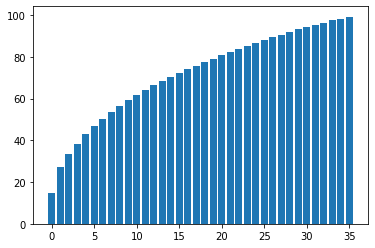

In [11]:
# PCA reduced

pca = PCA()
pca.fit_transform(X_train_scl)
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.99:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 99% of the variance. From 7129 features to ", k, sep='')

pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train_scl)
X_train_pca = pca.transform(X_train_scl)
X_test_pca = pca.transform(X_test_scl)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

In [12]:
# X,y reduced by PCA

pca36 = PCA(n_components=36).fit(X_train_scl)
X_train_reduced = pca36.transform(X_train_scl)
X_test_reduced = pca36.transform(X_test_scl)

In [13]:
X_train_reduced.shape
X_test_reduced.shape

(34, 36)

with k = 4 score = 0.9919894650894906
---------------------------
Bảng thành phần chính
[[-10.62066844 -24.30848997   4.71674367   0.72519393]
 [ -6.1132637    0.70182839 -17.93246305 -28.23559588]
 [ -6.42703536 -43.66213256  21.91056488   2.56994932]
 [ -6.35275537 -23.28484156   0.96341609   4.89577485]
 [-28.27199703  24.79170982  -0.20595023  -8.36266293]
 [-10.03025638 -19.13381283 -13.30001237  17.27314006]
 [ -0.09608311 -31.51422924  -2.49821751   4.59459722]
 [  7.89248915 -56.79710598   3.99664734   3.66097767]
 [-14.86660054 -12.75146836  15.6513687  -13.21611144]
 [ -9.70832632   0.28853007 -17.52017757   0.54694299]
 [-13.31581981   3.52838783 -11.70620106  -8.52888811]
 [ -4.81040202   3.51656192 -35.66268687   9.47881649]
 [-31.41478238  18.08216899   1.72628127  -4.0172416 ]
 [-15.78973808  -0.29089693  -2.65813931  -6.26005415]
 [-33.49825078  21.06409979   4.11650559  -2.38842239]
 [-19.65315264   0.39744815  -1.93455526   1.75355861]
 [-11.71382845 -24.45980625  44.

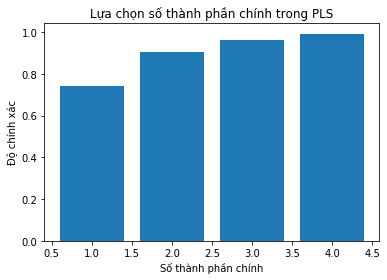

In [15]:
# PLS reduced

from sklearn.cross_decomposition import PLSRegression
k = 0
range_k = []
score = 0
range_score = []

while score <0.99:
    k += 1
    range_k.append(k)
    pls = PLSRegression(n_components=k)
    pls.fit(X_train_scl, y_train.iloc[:,1])
    score = pls.score(X_train_scl, y_train.iloc[:,1], sample_weight=None)
    range_score.append(score)
print("with k =", range_k[-1], "score =", range_score[-1])
plt.title("Lựa chọn số thành phần chính trong PLS")
plt.xlabel("Số thành phần chính")
plt.ylabel("Độ chính xác")
plt.bar(range_k, range_score)
print("---------------------------")
print("Bảng thành phần chính")
pls = PLSRegression(n_components=range_k[-1])
pls.fit(X_train_scl, y_train.iloc[:,1])
X_train_pls, y_train_pls = pls.transform(X_train_scl, y_train.iloc[:,1])
X_test_pls, y_test_pls = pls.transform(X_test_scl, y_test.iloc[:,1])
print(X_train_pls)

### 2.2 Machine Learning Models

K-means accuracy: 0.765


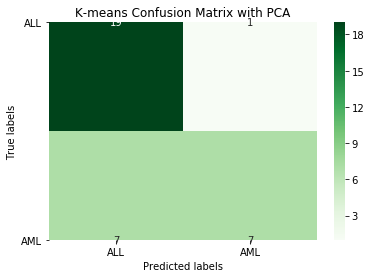

In [16]:
# K-Means Clustering with PCA

kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_reduced)
km_pred_pca = kmeans.predict(X_test_reduced)

print('K-means accuracy:', round(accuracy_score(y_test.iloc[:,1], km_pred_pca), 3))

cm_km_pca = confusion_matrix(y_test.iloc[:,1], km_pred_pca)

ax = plt.subplot()
sns.heatmap(cm_km_pca, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('K-means Confusion Matrix with PCA') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

K-means accuracy: 0.853


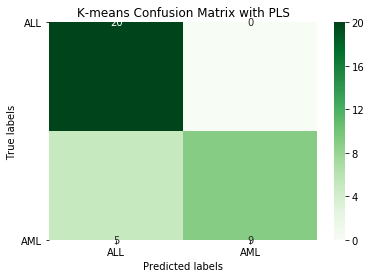

In [17]:
# K-Means Clustering with PLS

kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_pls)
km_pred = kmeans.predict(X_test_pls)

print('K-means accuracy:', round(accuracy_score(y_test.iloc[:,1], km_pred), 3))

cm_km = confusion_matrix(y_test.iloc[:,1], km_pred)

ax = plt.subplot()
sns.heatmap(cm_km, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('K-means Confusion Matrix with PLS') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Naive Bayes accuracy: 0.676


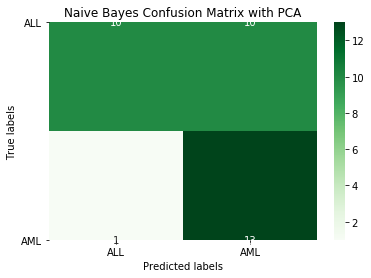

In [22]:
# Naive Bayes with PCA

# Create a Gaussian classifier
nb_model = GaussianNB()

nb_model.fit(X_train_reduced, y_train.iloc[:,1])

nb_pred_pca = nb_model.predict(X_test_reduced)

print('Naive Bayes accuracy:', round(accuracy_score(y_test.iloc[:,1], nb_pred_pca), 3))

cm_nb_pca =  confusion_matrix(y_test.iloc[:,1], nb_pred_pca)

ax = plt.subplot()
sns.heatmap(cm_nb_pca, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Naive Bayes Confusion Matrix with PCA') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Naive Bayes accuracy: 0.794


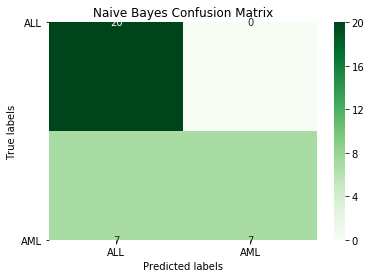

In [20]:
# Naive Bayes with PLS

# Create a Gaussian classifier
nb_model = GaussianNB()

nb_model.fit(X_train_pls, y_train.iloc[:,1])

nb_pred = nb_model.predict(X_test_pls)

print('Naive Bayes accuracy:', round(accuracy_score(y_test.iloc[:,1], nb_pred), 3))

cm_nb =  confusion_matrix(y_test.iloc[:,1], nb_pred)

ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Naive Bayes Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Best Parameters:
 {'C': 10, 'penalty': 'l1'}
Logistic Regression accuracy: 0.882


C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


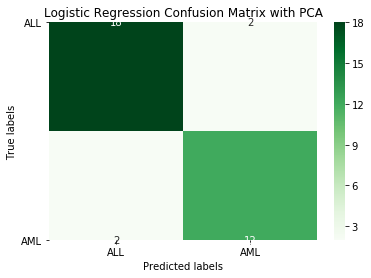

In [24]:
# Logistic Regression with PCA

log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

log_model.fit(X_train_reduced, y_train.iloc[:,1])

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred_pca = best_log.predict(X_test_reduced)

print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred_pca), 3))

cm_log_pca =  confusion_matrix(y_test.iloc[:,1], log_pred_pca)

ax = plt.subplot()
sns.heatmap(cm_log_pca, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix with PCA') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'C': 0.001, 'penalty': 'l2'}
Logistic Regression accuracy: 0.882


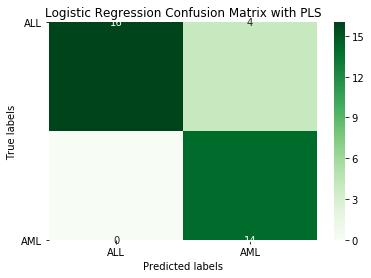

In [26]:
# Logistic Regression with PLS

log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

log_model.fit(X_train_pls, y_train.iloc[:,1])

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test_pls)

print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred), 3))

cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix with PLS') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 0.912


C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


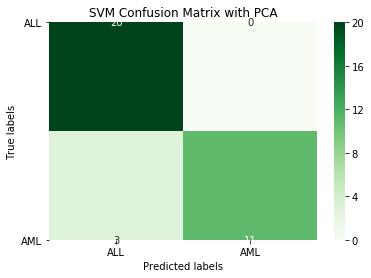

In [28]:
# Support Vector Machine with PCA

# Parameter grid
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10], "kernel": ["linear", "rbf", "poly"], "decision_function_shape" : ["ovo", "ovr"]} 

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# Train the classifier
svm_grid.fit(X_train_reduced, y_train.iloc[:,1])

print("Best Parameters:\n", svm_grid.best_params_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred_pca = best_svc.predict(X_test_reduced)

print('SVM accuracy:', round(accuracy_score(y_test.iloc[:,1], svm_pred_pca), 3))

cm_svm_pca =  confusion_matrix(y_test.iloc[:,1], svm_pred_pca)

ax = plt.subplot()
sns.heatmap(cm_svm_pca, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix with PCA') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 0.882


C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


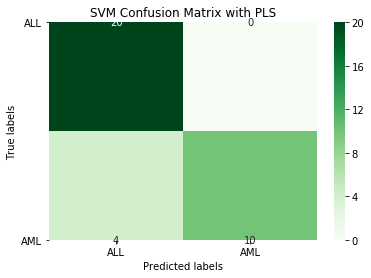

In [36]:
# Support Vector Machine with PLS

# Parameter grid
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10], "kernel": ["linear", "rbf", "poly"], "decision_function_shape" : ["ovo", "ovr"]} 

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# Train the classifier
svm_grid.fit(X_train_pls, y_train.iloc[:,1])

print("Best Parameters:\n", svm_grid.best_params_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred = best_svc.predict(X_test_pls)

print('SVM accuracy:', round(accuracy_score(y_test.iloc[:,1], svm_pred), 3))

cm_svm =  confusion_matrix(y_test.iloc[:,1], svm_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix with PLS') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 10, 'min_samples_split': 3, 'n_estimators': 60}
Random Forest accuracy: 0.676


C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


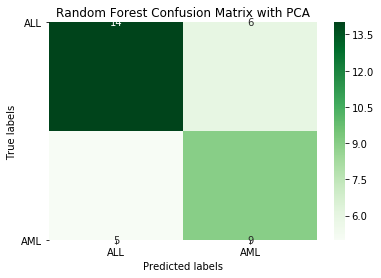

In [37]:
# Random Forest with PCA

# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')

# Fine-tune the hyperparameters
rf_model.fit(X_train_reduced, y_train.iloc[:,1])

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred_pca = rf_model_best.predict(X_test_reduced)

print('Random Forest accuracy:', round(accuracy_score(y_test.iloc[:,1], rf_pred_pca), 3))

cm_rf_pca = confusion_matrix(y_test.iloc[:,1], rf_pred_pca)

ax = plt.subplot()
sns.heatmap(cm_rf_pca, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Random Forest Confusion Matrix with PCA') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 12, 'min_samples_split': 3, 'n_estimators': 60}
Random Forest accuracy: 0.824


C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


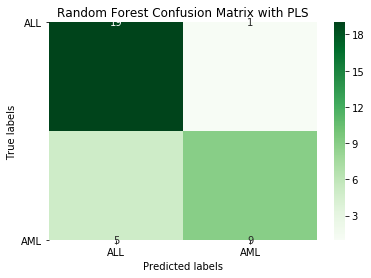

In [38]:
# Random Forest with PLS

# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')

# Fine-tune the hyperparameters
rf_model.fit(X_train_pls, y_train.iloc[:,1])

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test_pls)

print('Random Forest accuracy:', round(accuracy_score(y_test.iloc[:,1], rf_pred), 3))

cm_rf = confusion_matrix(y_test.iloc[:,1], rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Random Forest Confusion Matrix with PLS') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Accuracy:  0.676


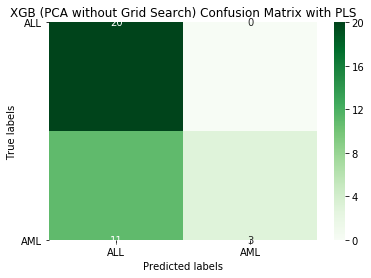

In [40]:
# XGB — PCA with no Grid Search 

xgb2_model = xgb.XGBClassifier()
xgb2_model.fit(X_train_reduced, y_train.iloc[:,1])

xgb2_pred_pca = xgb2_model.predict(X_test_reduced)

print('Accuracy: ', round(accuracy_score(y_test.iloc[:,1], xgb2_pred_pca), 3))

cm_xgb2_pca = confusion_matrix(y_test.iloc[:,1], xgb2_pred_pca)

ax = plt.subplot()
sns.heatmap(cm_xgb2_pca, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('XGB (PCA without Grid Search) Confusion Matrix with PLS') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Accuracy:  0.853


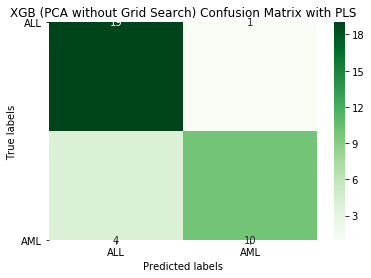

In [42]:
# XGB — PLS with no Grid Search 

xgb2_model = xgb.XGBClassifier()
xgb2_model.fit(X_train_pls, y_train.iloc[:,1])

xgb2_pred = xgb2_model.predict(X_test_pls)

print('Accuracy: ', round(accuracy_score(y_test.iloc[:,1], xgb2_pred), 3))

cm_xgb2 = confusion_matrix(y_test.iloc[:,1], xgb2_pred)

ax = plt.subplot()
sns.heatmap(cm_xgb2, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('XGB (PCA without Grid Search) Confusion Matrix with PLS') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

### 2.3 Artificial neural network

Epoch 1/100
38/38 [==============================] - 0s 13ms/step - loss: 0.6925 - accuracy: 0.4737
Epoch 2/100
38/38 [==============================] - 0s 709us/step - loss: 0.6215 - accuracy: 0.7368
Epoch 3/100
38/38 [==============================] - 0s 656us/step - loss: 0.5728 - accuracy: 0.7105
Epoch 4/100
38/38 [==============================] - 0s 814us/step - loss: 0.5427 - accuracy: 0.7105
Epoch 5/100
38/38 [==============================] - 0s 709us/step - loss: 0.5180 - accuracy: 0.7105
Epoch 6/100
38/38 [==============================] - 0s 761us/step - loss: 0.4986 - accuracy: 0.7105
Epoch 7/100
38/38 [==============================] - 0s 840us/step - loss: 0.4730 - accuracy: 0.7105
Epoch 8/100
38/38 [==============================] - 0s 814us/step - loss: 0.4480 - accuracy: 0.7368
Epoch 9/100
38/38 [==============================] - 0s 840us/step - loss: 0.4228 - accuracy: 0.7632
Epoch 10/100
38/38 [==============================] - 0s 945us/step - loss: 0.3947 - accurac

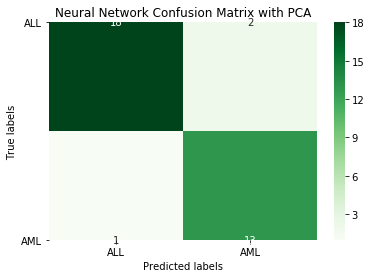

In [76]:
# ANN with PCA

# Create model architecture
model = Sequential()
model.add(Dense(19, activation='sigmoid', input_shape=(36,)))
# model.add(Dense(89, activation='sigmoid'))
# model.add(Dense(25, activation='sigmoid'))
model.add(Dense(18, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='nadam',
loss='binary_crossentropy',
metrics=['accuracy'])

# Create training/validation sets
# partial_X_train = X_train_scl[:32]
# X_val = X_train_scl[32:]

# y_train_label = y_train.iloc[:,1]
# partial_y_train = y_train_label[:32]
# y_val = y_train_label[32:]

# Set up early stopping
# es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

# Fit model
history = model.fit(X_train_reduced,
            y_train.iloc[:,1],
            epochs=100,
            batch_size=2)

# Make predictions
nn_pred_pca = model.predict_classes(X_test_reduced)

print('Neural Network accuracy: ', round(accuracy_score(y_test.iloc[:,1], nn_pred_pca), 3))

cm_nn_pca = confusion_matrix(y_test.iloc[:,1], nn_pred_pca)

ax = plt.subplot()
sns.heatmap(cm_nn_pca, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Neural Network Confusion Matrix with PCA') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

In [75]:
# Check optimal for ANN

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm

input_dim = X_train_pls.shape[1]
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

def create_model():
    
    # default values
    activation='sigmoid' # or linear
    dropout_rate=0.0 # or 0.2
    init_mode='uniform'
    weight_constraint=0 # or  4
    optimizer='nadam' # or SGD
    lr = 0.01
    momemntum=0
        
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=input_dim, kernel_initializer=init_mode, 
                    activation=activation,
                    kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(12, kernel_initializer=init_mode, activation='sigmoid'))
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
    
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# Use scikit-learn to grid search 
activation =  ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weight_constraint=[1, 2, 3, 4, 5]
neurons = [1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60]
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

# grid search epochs, batch size
epochs = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200] # add 50, 100, 150 etc
batch_size = [2,3,4,5,6,7,8,9,10] # add 5, 10, 20, 40, 60, 80, 100 etc
param_grid = dict(epochs=epochs, batch_size=batch_size)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train_pls, y_train.iloc[:,1]) 

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.710526 using {'batch_size': 2, 'epochs': 10}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 10}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 20}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 30}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 40}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 50}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 60}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 70}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 80}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 90}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 100}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 110}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 120}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 130}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 140}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 150}
0.710526 (0.426094) with: {'batch_size': 2, 'epochs': 160}
0.710526 (0.

Epoch 1/100
38/38 [==============================] - 0s 13ms/step - loss: 0.6448 - accuracy: 0.8158
Epoch 2/100
38/38 [==============================] - 0s 814us/step - loss: 0.6194 - accuracy: 0.8421
Epoch 3/100
38/38 [==============================] - 0s 787us/step - loss: 0.5953 - accuracy: 0.7105
Epoch 4/100
38/38 [==============================] - 0s 682us/step - loss: 0.5722 - accuracy: 0.7105
Epoch 5/100
38/38 [==============================] - 0s 682us/step - loss: 0.5528 - accuracy: 0.7105
Epoch 6/100
38/38 [==============================] - 0s 919us/step - loss: 0.5343 - accuracy: 0.7105
Epoch 7/100
38/38 [==============================] - 0s 971us/step - loss: 0.5189 - accuracy: 0.7105
Epoch 8/100
38/38 [==============================] - 0s 840us/step - loss: 0.5053 - accuracy: 0.7105
Epoch 9/100
38/38 [==============================] - 0s 919us/step - loss: 0.4910 - accuracy: 0.7105
Epoch 10/100
38/38 [==============================] - 0s 919us/step - loss: 0.4761 - accurac

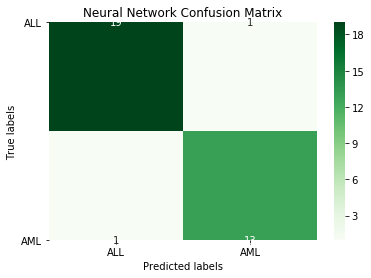

In [79]:
# ANN with PLS

# Create model architecture
model = Sequential()
model.add(Dense(5, activation='sigmoid', input_shape=(4,)))
# model.add(Dense(89, activation='sigmoid'))
# model.add(Dense(25, activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='nadam',
loss='binary_crossentropy',
metrics=['accuracy'])

# Create training/validation sets
# partial_X_train = X_train_scl[:32]
# X_val = X_train_scl[32:]

# y_train_label = y_train.iloc[:,1]
# partial_y_train = y_train_label[:32]
# y_val = y_train_label[32:]

# Set up early stopping
# es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

# Fit model
history = model.fit(X_train_pls, y_train.iloc[:,1],epochs=100,batch_size=2)

# Make predictions
nn_pred = model.predict_classes(X_test_pls)

print('Neural Network accuracy: ', round(accuracy_score(y_test.iloc[:,1], nn_pred), 3))

cm_nn = confusion_matrix(y_test.iloc[:,1], nn_pred)

ax = plt.subplot()
sns.heatmap(cm_nn, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Neural Network Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

## 3 Accuracy evaluate methods

In [83]:
# Classification Accuracy

# importing the required module
from sklearn import metrics

# Confuse matrix

print ("Confusion Matrix of K-Means:", cm_km)
print ("Confusion Matrix of Naive Bayes:", cm_nb)
print ("Confusion Matrix of Logistic Regression:", cm_log)
print ("Confusion Matrix of SVM:", cm_svm)
print ("Confusion Matrix of Random Forest:", cm_rf)
print ("Confusion Matrix of XG Boost:", cm_xgb2)
print ("Confusion Matrix of ANN:", cm_nn)


Confusion Matrix of K-Means: [[20  0]
 [ 5  9]]
Confusion Matrix of Naive Bayes: [[20  0]
 [ 7  7]]
Confusion Matrix of Logistic Regression: [[16  4]
 [ 0 14]]
Confusion Matrix of SVM: [[20  0]
 [ 4 10]]
Confusion Matrix of Random Forest: [[19  1]
 [ 5  9]]
Confusion Matrix of XG Boost: [[19  1]
 [ 4 10]]
Confusion Matrix of ANN: [[19  1]
 [ 1 13]]


In [102]:
# Accuracy PLS

print ("Accuracy of K-Means:", round(metrics.accuracy_score(y_test.iloc[:,1], km_pred),3))
print ("Accuracy of Naive Bayes:", round(metrics.accuracy_score(y_test.iloc[:,1], nb_pred),3))
print ("Accuracy of Logistic Regression:",  round(metrics.accuracy_score(y_test.iloc[:,1], log_pred),3))
print ("Accuracy of SVM:", round(metrics.accuracy_score(y_test.iloc[:,1], svm_pred),3))
print ("Accuracy of Random Forest:", round(metrics.accuracy_score(y_test.iloc[:,1], rf_pred),3))
print ("Accuracy of XG Boost:", round(metrics.accuracy_score(y_test.iloc[:,1], xgb2_pred),3))
print ("Accuracy of ANN:", round(metrics.accuracy_score(y_test.iloc[:,1], nn_pred),3))

Accuracy of K-Means: 0.971
Accuracy of Naive Bayes: 0.824
Accuracy of Logistic Regression: 0.941
Accuracy of SVM: 0.941
Accuracy of Random Forest: 0.912
Accuracy of XG Boost: 0.941
Accuracy of ANN: 0.971


In [105]:
# Accuracy PCA

print ("Accuracy of K-Means:", round(metrics.accuracy_score(y_test.iloc[:,1], km_pred_pca),3))
print ("Accuracy of Naive Bayes:", round(metrics.accuracy_score(y_test.iloc[:,1], nb_pred_pca),3))
print ("Accuracy of Logistic Regression:",  round(metrics.accuracy_score(y_test.iloc[:,1], log_pred_pca),3))
print ("Accuracy of SVM:", round(metrics.accuracy_score(y_test.iloc[:,1], svm_pred_pca),3))
print ("Accuracy of Random Forest:", round(metrics.accuracy_score(y_test.iloc[:,1], rf_pred_pca),3))
print ("Accuracy of XG Boost:", round(metrics.accuracy_score(y_test.iloc[:,1], xgb2_pred_pca),3))
print ("Accuracy of ANN:", round(metrics.accuracy_score(y_test.iloc[:,1], nn_pred_pca),3))

Accuracy of K-Means: 0.765
Accuracy of Naive Bayes: 0.676
Accuracy of Logistic Regression: 0.882
Accuracy of SVM: 0.912
Accuracy of Random Forest: 0.676
Accuracy of XG Boost: 0.676
Accuracy of ANN: 0.853


In [87]:
# Classification Error

# Misclassification Rate

print ("Classification Error of K-Means:", 1 - metrics.accuracy_score(y_test.iloc[:,1], km_pred))
print ("Classification Error of Naive Bayes:", 1 - metrics.accuracy_score(y_test.iloc[:,1], nb_pred))
print ("Classification Error of Logistic Regression:", 1 - metrics.accuracy_score(y_test.iloc[:,1], log_pred))
print ("Classification Error of SVM:", 1 - metrics.accuracy_score(y_test.iloc[:,1], svm_pred))
print ("Classification Error of Random Forest:", 1 - metrics.accuracy_score(y_test.iloc[:,1], rf_pred))
print ("Classification Error of XG Boost:", 1 - metrics.accuracy_score(y_test.iloc[:,1], xgb2_pred))
print ("Classification Error of ANN:", 1 - metrics.accuracy_score(y_test.iloc[:,1], nn_pred))

Classification Error of K-Means: 0.1470588235294118
Classification Error of Naive Bayes: 0.20588235294117652
Classification Error of Logistic Regression: 0.11764705882352944
Classification Error of SVM: 0.11764705882352944
Classification Error of Random Forest: 0.17647058823529416
Classification Error of XG Boost: 0.1470588235294118
Classification Error of ANN: 0.05882352941176472


In [107]:
# Sensitivity PLS

print ("Sensitivity of K-Means:", metrics.recall_score(y_test.iloc[:,1], km_pred, average='weighted'))
print ("Sensitivity of Naive Bayes:", metrics.recall_score(y_test.iloc[:,1], nb_pred, average='weighted'))
print ("Sensitivity of Logistic Regression:", metrics.recall_score(y_test.iloc[:,1], log_pred, average='weighted'))
print ("Sensitivity of SVM:", metrics.recall_score(y_test.iloc[:,1], svm_pred, average='weighted'))
print ("Sensitivity of Random Forest:", metrics.recall_score(y_test.iloc[:,1], rf_pred, average='weighted'))
print ("Sensitivity of XG Boost:", metrics.recall_score(y_test.iloc[:,1], xgb2_pred, average='weighted'))
print ("Sensitivity of ANN:", metrics.recall_score(y_test.iloc[:,1], nn_pred, average='weighted'))

Sensitivity of K-Means: 0.9705882352941176
Sensitivity of Naive Bayes: 0.8235294117647058
Sensitivity of Logistic Regression: 0.9411764705882353
Sensitivity of SVM: 0.9411764705882353
Sensitivity of Random Forest: 0.9117647058823529
Sensitivity of XG Boost: 0.9411764705882353
Sensitivity of ANN: 0.9705882352941176


In [108]:
# Sensitivity PCA

print ("Sensitivity of K-Means:", metrics.recall_score(y_test.iloc[:,1], km_pred_pca, average='weighted'))
print ("Sensitivity of Naive Bayes:", metrics.recall_score(y_test.iloc[:,1], nb_pred_pca, average='weighted'))
print ("Sensitivity of Logistic Regression:", metrics.recall_score(y_test.iloc[:,1], log_pred_pca, average='weighted'))
print ("Sensitivity of SVM:", metrics.recall_score(y_test.iloc[:,1], svm_pred_pca, average='weighted'))
print ("Sensitivity of Random Forest:", metrics.recall_score(y_test.iloc[:,1], rf_pred_pca, average='weighted'))
print ("Sensitivity of XG Boost:", metrics.recall_score(y_test.iloc[:,1], xgb2_pred_pca, average='weighted'))
print ("Sensitivity of ANN:", metrics.recall_score(y_test.iloc[:,1], nn_pred, average='weighted'))

Sensitivity of K-Means: 0.7647058823529411
Sensitivity of Naive Bayes: 0.6764705882352942
Sensitivity of Logistic Regression: 0.8823529411764706
Sensitivity of SVM: 0.9117647058823529
Sensitivity of Random Forest: 0.6764705882352942
Sensitivity of XG Boost: 0.6764705882352942
Sensitivity of ANN: 0.9705882352941176


In [71]:
# Precision : TP / (TP + FP) ( PLS)

print ("Precision of K-Means:", metrics.precision_score(y_test.iloc[:,1], km_pred, average='weighted'))
print ("Precision of Naive Bayes:", metrics.precision_score(y_test.iloc[:,1], nb_pred, average='weighted'))
print ("Precision of Logistic Regression:", metrics.precision_score(y_test.iloc[:,1], log_pred, average='weighted'))
print ("Precision of SVM:", metrics.precision_score(y_test.iloc[:,1], svm_pred, average='weighted'))
print ("Precision of Random Forest:", metrics.precision_score(y_test.iloc[:,1], rf_pred, average='weighted'))
print ("Precision of XG Boost:", metrics.precision_score(y_test.iloc[:,1], xgb_pred, average='weighted'))
print ("Precision of ANN:", metrics.precision_score(y_test.iloc[:,1], nn_pred, average='weighted'))

Precision of K-Means: 0.7342478493373633
Precision of Naive Bayes: 0.8642533936651584
Precision of Logistic Regression: 0.9141382868937048
Precision of SVM: 0.9232736572890026
Precision of Random Forest: 0.790158371040724
Precision of XG Boost: 0.790158371040724
Precision of ANN: 0.9141382868937048


In [110]:
# Precision : TP / (TP + FP) ( PCA)

print ("Precision of K-Means:", metrics.precision_score(y_test.iloc[:,1], km_pred_pca, average='weighted'))
print ("Precision of Naive Bayes:", metrics.precision_score(y_test.iloc[:,1], nb_pred_pca, average='weighted'))
print ("Precision of Logistic Regression:", metrics.precision_score(y_test.iloc[:,1], log_pred_pca, average='weighted'))
print ("Precision of SVM:", metrics.precision_score(y_test.iloc[:,1], svm_pred_pca, average='weighted'))
print ("Precision of Random Forest:", metrics.precision_score(y_test.iloc[:,1], rf_pred_pca, average='weighted'))
print ("Precision of XG Boost:", metrics.precision_score(y_test.iloc[:,1], xgb2_pred_pca, average='weighted'))
print ("Precision of ANN:", metrics.precision_score(y_test.iloc[:,1], nn_pred_pca, average='weighted'))

Precision of K-Means: 0.790158371040724
Precision of Naive Bayes: 0.7674959311787956
Precision of Logistic Regression: 0.8823529411764706
Precision of SVM: 0.9232736572890026
Precision of Random Forest: 0.6804953560371516
Precision of XG Boost: 0.7912713472485768
Precision of ANN: 0.8602650546384562


In [72]:
# F-measure : 2 P R / (P + R) (PLS)

print ("F-measure of K-Means:", metrics.f1_score(y_test.iloc[:,1], km_pred, average='weighted'))
print ("F-measure of Naive Bayes:", metrics.f1_score(y_test.iloc[:,1], nb_pred, average='weighted'))
print ("F-measure of Logistic Regression:", metrics.f1_score(y_test.iloc[:,1], log_pred, average='weighted'))
print ("F-measure of SVM:", metrics.f1_score(y_test.iloc[:,1], svm_pred, average='weighted'))
print ("F-measure of Random Forest:", metrics.f1_score(y_test.iloc[:,1], rf_pred, average='weighted'))
print ("F-measure of XG Boost:", metrics.f1_score(y_test.iloc[:,1], xgb_pred, average='weighted'))
print ("F-measure of ANN:", metrics.f1_score(y_test.iloc[:,1], nn_pred, average='weighted'))

F-measure of K-Means: 0.7286456908344734
F-measure of Naive Bayes: 0.810974192048361
F-measure of Logistic Regression: 0.9121547823373382
F-measure of SVM: 0.9095485636114912
F-measure of Random Forest: 0.7479655893978145
F-measure of XG Boost: 0.7479655893978145
F-measure of ANN: 0.9121547823373382


In [111]:
# F-measure : 2 P R / (P + R) (PCA)

print ("F-measure of K-Means:", metrics.f1_score(y_test.iloc[:,1], km_pred_pca, average='weighted'))
print ("F-measure of Naive Bayes:", metrics.f1_score(y_test.iloc[:,1], nb_pred_pca, average='weighted'))
print ("F-measure of Logistic Regression:", metrics.f1_score(y_test.iloc[:,1], log_pred_pca, average='weighted'))
print ("F-measure of SVM:", metrics.f1_score(y_test.iloc[:,1], svm_pred_pca, average='weighted'))
print ("F-measure of Random Forest:", metrics.f1_score(y_test.iloc[:,1], rf_pred_pca, average='weighted'))
print ("F-measure of XG Boost:", metrics.f1_score(y_test.iloc[:,1], xgb2_pred_pca, average='weighted'))
print ("F-measure of ANN:", metrics.f1_score(y_test.iloc[:,1], nn_pred_pca, average='weighted'))

F-measure of K-Means: 0.7479655893978145
F-measure of Naive Bayes: 0.6688548130673366
F-measure of Logistic Regression: 0.8823529411764706
F-measure of SVM: 0.9095485636114912
F-measure of Random Forest: 0.6779008685702398
F-measure of XG Boost: 0.6066897347174163
F-measure of ANN: 0.8492476060191521


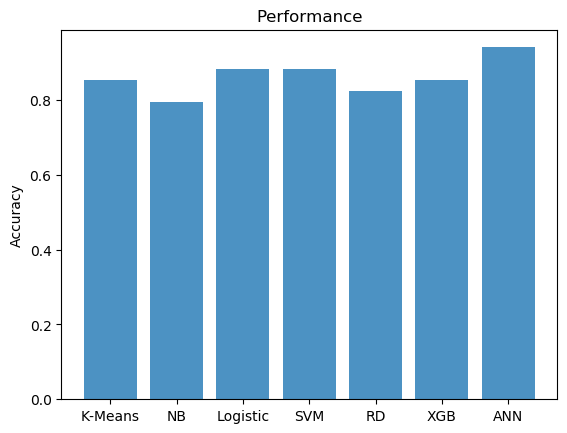

In [85]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('K-Means', 'NB', 'Logistic', 'SVM', 'RD', 'XGB' , 'ANN')
y_pos = np.arange(len(objects))
performance = [round(metrics.accuracy_score(y_test.iloc[:,1], km_pred),3),
               round(metrics.accuracy_score(y_test.iloc[:,1], nb_pred),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], log_pred),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], svm_pred),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], rf_pred),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], xgb2_pred),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], nn_pred),3)]

# fig, ax = plt.subplots()
# bar_width = 0.1
plt.bar(y_pos, performance, align='center', alpha=0.8)
plt.xticks(y_pos, objects )
plt.ylabel('Accuracy')
plt.title('Performance')

plt.show()

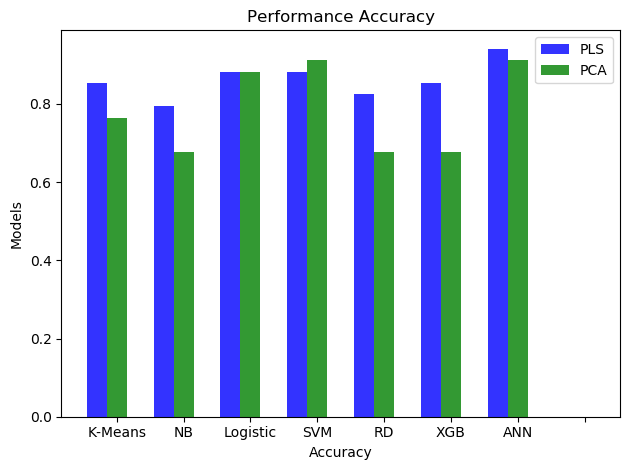

In [88]:
# Data to plot : Accuracy

n_groups = 8
PLS = [round(metrics.accuracy_score(y_test.iloc[:,1], km_pred),3),
               round(metrics.accuracy_score(y_test.iloc[:,1], nb_pred),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], log_pred),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], svm_pred),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], rf_pred),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], xgb2_pred),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], nn_pred),3), 0]

PCA = [round(metrics.accuracy_score(y_test.iloc[:,1], km_pred_pca),3),
               round(metrics.accuracy_score(y_test.iloc[:,1], nb_pred_pca),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], log_pred_pca),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], svm_pred_pca),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], rf_pred_pca),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], xgb2_pred_pca),3),
                 round(metrics.accuracy_score(y_test.iloc[:,1], nn_pred_pca),3), 0]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, PLS, bar_width,
alpha=opacity,
color='b',
label='PLS')

rects2 = plt.bar(index + bar_width, PCA , bar_width,
alpha=opacity,
color='g',
label='PCA')

plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.title('Performance Accuracy')
plt.xticks(index + bar_width, ('K-Means', 'NB', 'Logistic', 'SVM', 'RD', 'XGB' , 'ANN'))
plt.legend()

plt.tight_layout()
plt.show()

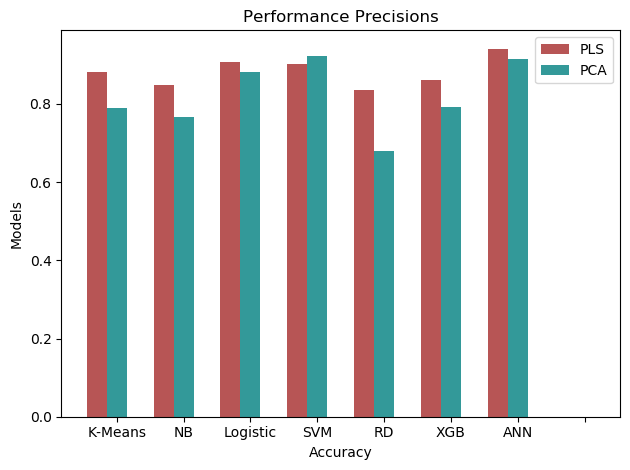

In [91]:
# Data to plot : Precisions

n_groups = 8
PLS_P = [metrics.precision_score(y_test.iloc[:,1], km_pred, average='weighted'),
 metrics.precision_score(y_test.iloc[:,1], nb_pred, average='weighted'),
 metrics.precision_score(y_test.iloc[:,1], log_pred, average='weighted'),
 metrics.precision_score(y_test.iloc[:,1], svm_pred, average='weighted'),
 metrics.precision_score(y_test.iloc[:,1], rf_pred, average='weighted'),
 metrics.precision_score(y_test.iloc[:,1], xgb2_pred, average='weighted'),
 metrics.precision_score(y_test.iloc[:,1], nn_pred, average='weighted'), 0]

PCA_P = [metrics.precision_score(y_test.iloc[:,1], km_pred_pca, average='weighted'),
 metrics.precision_score(y_test.iloc[:,1], nb_pred_pca, average='weighted'),
 metrics.precision_score(y_test.iloc[:,1], log_pred_pca, average='weighted'),
 metrics.precision_score(y_test.iloc[:,1], svm_pred_pca, average='weighted'),
 metrics.precision_score(y_test.iloc[:,1], rf_pred_pca, average='weighted'),
 metrics.precision_score(y_test.iloc[:,1], xgb2_pred_pca, average='weighted'),
 metrics.precision_score(y_test.iloc[:,1], nn_pred_pca, average='weighted'), 0]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, PLS_P, bar_width,
alpha=opacity,
color='brown',
label='PLS')

rects2 = plt.bar(index + bar_width, PCA_P , bar_width,
alpha=opacity,
color='teal',
label='PCA')

plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.title('Performance Precisions')
plt.xticks(index + bar_width, ('K-Means', 'NB', 'Logistic', 'SVM', 'RD', 'XGB' , 'ANN'))
plt.legend()

plt.tight_layout()
plt.show()

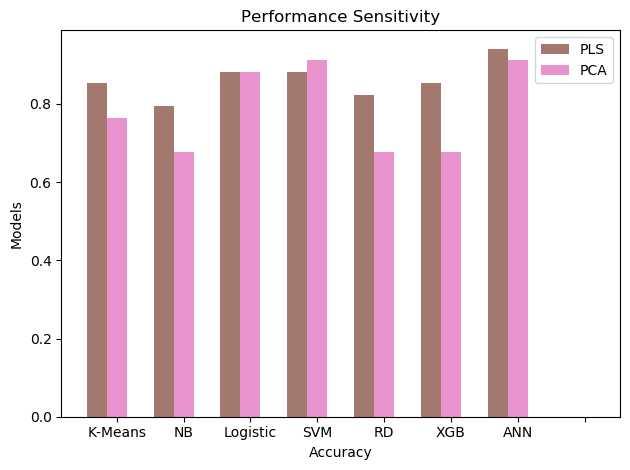

In [95]:
# Data to plot : Sensitivity

n_groups = 8
PLS_S = [metrics.recall_score(y_test.iloc[:,1], km_pred, average='weighted'),
 metrics.recall_score(y_test.iloc[:,1], nb_pred, average='weighted'),
 metrics.recall_score(y_test.iloc[:,1], log_pred, average='weighted'),
 metrics.recall_score(y_test.iloc[:,1], svm_pred, average='weighted'),
 metrics.recall_score(y_test.iloc[:,1], rf_pred, average='weighted'),
 metrics.recall_score(y_test.iloc[:,1], xgb2_pred, average='weighted'),
 metrics.recall_score(y_test.iloc[:,1], nn_pred, average='weighted'), 0]

PCA_S = [metrics.recall_score(y_test.iloc[:,1], km_pred_pca, average='weighted'),
 metrics.recall_score(y_test.iloc[:,1], nb_pred_pca, average='weighted'),
 metrics.recall_score(y_test.iloc[:,1], log_pred_pca, average='weighted'),
 metrics.recall_score(y_test.iloc[:,1], svm_pred_pca, average='weighted'),
 metrics.recall_score(y_test.iloc[:,1], rf_pred_pca, average='weighted'),
 metrics.recall_score(y_test.iloc[:,1], xgb2_pred_pca, average='weighted'),
 metrics.recall_score(y_test.iloc[:,1], nn_pred_pca, average='weighted'), 0]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, PLS_S, bar_width,
alpha=opacity,
color='tab:brown',
label='PLS')

rects2 = plt.bar(index + bar_width, PCA_S , bar_width,
alpha=opacity,
color='tab:pink',
label='PCA')

plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.title('Performance Sensitivity')
plt.xticks(index + bar_width, ('K-Means', 'NB', 'Logistic', 'SVM', 'RD', 'XGB' , 'ANN'))
plt.legend()

plt.tight_layout()
plt.show()

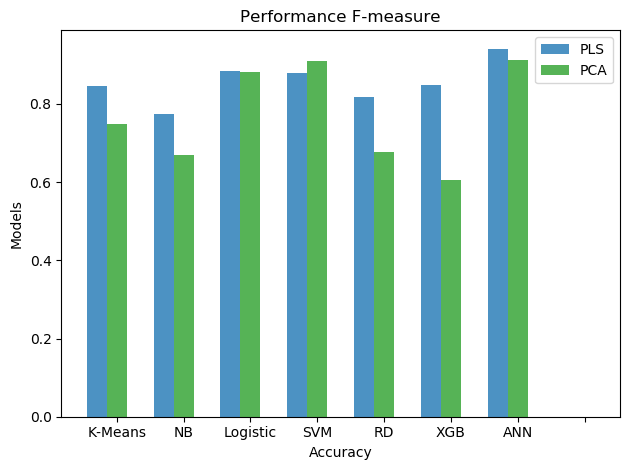

In [98]:
# Data to plot : F-measure

n_groups = 8
PLS_F = [metrics.f1_score(y_test.iloc[:,1], km_pred, average='weighted'),
 metrics.f1_score(y_test.iloc[:,1], nb_pred, average='weighted'),
 metrics.f1_score(y_test.iloc[:,1], log_pred, average='weighted'),
 metrics.f1_score(y_test.iloc[:,1], svm_pred, average='weighted'),
 metrics.f1_score(y_test.iloc[:,1], rf_pred, average='weighted'),
 metrics.f1_score(y_test.iloc[:,1], xgb2_pred, average='weighted'),
 metrics.f1_score(y_test.iloc[:,1], nn_pred, average='weighted'), 0]

PCA_F = [metrics.f1_score(y_test.iloc[:,1], km_pred_pca, average='weighted'),
 metrics.f1_score(y_test.iloc[:,1], nb_pred_pca, average='weighted'),
 metrics.f1_score(y_test.iloc[:,1], log_pred_pca, average='weighted'),
 metrics.f1_score(y_test.iloc[:,1], svm_pred_pca, average='weighted'),
 metrics.f1_score(y_test.iloc[:,1], rf_pred_pca, average='weighted'),
 metrics.f1_score(y_test.iloc[:,1], xgb2_pred_pca, average='weighted'),
 metrics.f1_score(y_test.iloc[:,1], nn_pred_pca, average='weighted'), 0]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, PLS_F, bar_width,
alpha=opacity,
color='tab:blue',
label='PLS')

rects2 = plt.bar(index + bar_width, PCA_F , bar_width,
alpha=opacity,
color='tab:green',
label='PCA')

plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.title('Performance F-measure')
plt.xticks(index + bar_width, ('K-Means', 'NB', 'Logistic', 'SVM', 'RD', 'XGB' , 'ANN'))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame{data(np.array nhé), index = , columns = }

In [99]:
# Statistical for PLS

PLS_Stat = { "Accuracy" : PLS[0:-1], "Sensitivity" : PLS_S[0:-1], "Precisions" : PLS_P[0:-1] , 'F-measure' : PLS_F[0:-1]}
PLS_Stat_pd = pd.DataFrame(PLS_Stat, index = ['K-Means', 'Naive Bayes', 'Logistic', 'SVM', 'Random Forest', 'XG Boots' , 'ANN'])
PLS_Stat_pd

PLS_Stat_pd.to_csv('H:/MASTER KHDL/ADVANCED MACHINE LEARNING/Cuoi Ky/PLS_Stat.csv',index = True)

In [100]:
# Statistical for PCA

PCA_Stat = { "Accuracy" : PCA[0:-1], "Sensitivity" : PCA_S[0:-1], "Precisions" : PCA_P[0:-1] , 'F-measure' : PCA_F[0:-1]}
PCA_Stat_pd = pd.DataFrame(PCA_Stat, index = ['K-Means', 'Naive Bayes', 'Logistic', 'SVM', 'Random Forest', 'XG Boots' , 'ANN'])
PCA_Stat_pd

PCA_Stat_pd.to_csv('H:/MASTER KHDL/ADVANCED MACHINE LEARNING/Cuoi Ky/PCA_Stat.csv',index = True)

In [101]:
# Statistical for PLS Confuse Matrix

PLS_TP = [cm_km[0,0], cm_nb[0,0] ,cm_log[0,0], cm_svm[0,0], cm_rf[0,0], cm_xgb2[0,0], cm_nn[0,0]]
PLS_FN = [cm_km[0,1], cm_nb[0,1] ,cm_log[0,1], cm_svm[0,1], cm_rf[0,1], cm_xgb2[0,1], cm_nn[0,1]]
PLS_FP = [cm_km[1,0], cm_nb[1,0] ,cm_log[1,0], cm_svm[1,0], cm_rf[1,0], cm_xgb2[1,0], cm_nn[1,0]]
PLS_TN = [cm_km[1,1], cm_nb[1,1] ,cm_log[1,1], cm_svm[1,1], cm_rf[1,1], cm_xgb2[1,1], cm_nn[1,1]]

PLS_CM = { 'TP' : PLS_TP , 'FN' : PLS_FN , 'FP' : PLS_FP , 'TN' : PLS_TN}

PLS_Stat_CM = pd.DataFrame(PLS_CM, index = ['K-Means', 'Naive Bayes', 'Logistic', 'SVM', 'Random Forest', 'XG Boots' , 'ANN'] )
PLS_Stat_CM.to_csv('H:/MASTER KHDL/ADVANCED MACHINE LEARNING/Cuoi Ky/PLS_Stat_CM.csv',index = True)

In [102]:
# Statistical for PCA Confuse Matrix

PCA_TP = [cm_km_pca[0,0], cm_nb_pca[0,0] ,cm_log_pca[0,0], cm_svm_pca[0,0], cm_rf_pca[0,0], cm_xgb2_pca[0,0], cm_nn_pca[0,0]]
PCA_FN = [cm_km_pca[0,1], cm_nb_pca[0,1] ,cm_log_pca[0,1], cm_svm_pca[0,1], cm_rf_pca[0,1], cm_xgb2_pca[0,1], cm_nn_pca[0,1]]
PCA_FP = [cm_km_pca[1,0], cm_nb_pca[1,0] ,cm_log_pca[1,0], cm_svm_pca[1,0], cm_rf_pca[1,0], cm_xgb2_pca[1,0], cm_nn_pca[1,0]]
PCA_TN = [cm_km_pca[1,1], cm_nb_pca[1,1] ,cm_log_pca[1,1], cm_svm_pca[1,1], cm_rf_pca[1,1], cm_xgb2_pca[1,1], cm_nn_pca[1,1]]

PCA_CM = { 'TP' : PCA_TP , 'FN' : PCA_FN , 'FP' : PCA_FP , 'TN' : PCA_TN}

PCA_Stat_CM = pd.DataFrame(PCA_CM, index = ['K-Means', 'Naive Bayes', 'Logistic', 'SVM', 'Random Forest', 'XG Boots' , 'ANN'] )
PCA_Stat_CM.to_csv('H:/MASTER KHDL/ADVANCED MACHINE LEARNING/Cuoi Ky/PCA_Stat_CM.csv',index = True)

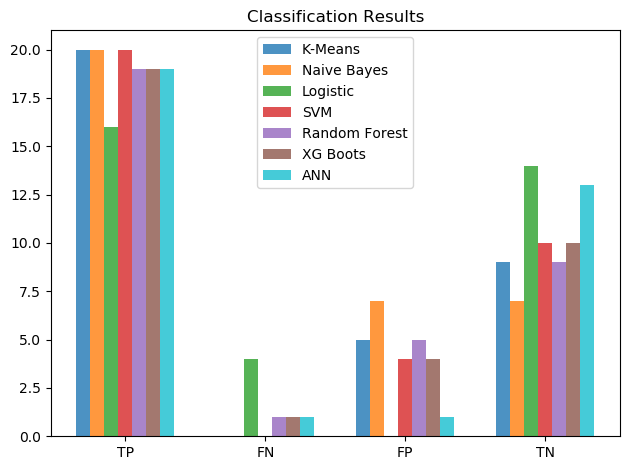

In [103]:
# Confuse Matrix PLS

# Data to plot : F-measure

n_groups = 4

# Divide
G_KM = [PLS_Stat_CM.iloc[0,0] , PLS_Stat_CM.iloc[0,1], PLS_Stat_CM.iloc[0,2], PLS_Stat_CM.iloc[0,3]]
G_NV = [PLS_Stat_CM.iloc[1,0] , PLS_Stat_CM.iloc[1,1], PLS_Stat_CM.iloc[1,2], PLS_Stat_CM.iloc[1,3]]
G_Log = [PLS_Stat_CM.iloc[2,0] , PLS_Stat_CM.iloc[2,1], PLS_Stat_CM.iloc[2,2], PLS_Stat_CM.iloc[2,3]]
G_SVM = [PLS_Stat_CM.iloc[3,0] , PLS_Stat_CM.iloc[3,1], PLS_Stat_CM.iloc[3,2], PLS_Stat_CM.iloc[3,3]]
G_RF = [PLS_Stat_CM.iloc[4,0] , PLS_Stat_CM.iloc[4,1], PLS_Stat_CM.iloc[4,2], PLS_Stat_CM.iloc[4,3]]
G_XGB = [PLS_Stat_CM.iloc[5,0] , PLS_Stat_CM.iloc[5,1], PLS_Stat_CM.iloc[5,2], PLS_Stat_CM.iloc[5,3]]
G_ANN = [PLS_Stat_CM.iloc[6,0] , PLS_Stat_CM.iloc[6,1], PLS_Stat_CM.iloc[6,2], PLS_Stat_CM.iloc[6,3]]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, G_KM, bar_width, alpha=opacity, color='tab:blue', label='K-Means')
rects2 = plt.bar(index + bar_width, G_NV, bar_width, alpha=opacity, color='tab:orange', label='Naive Bayes')
rects3 = plt.bar(index + bar_width*2, G_Log, bar_width, alpha=opacity, color='tab:green', label='Logistic')
rects4 = plt.bar(index+ bar_width*3, G_SVM, bar_width, alpha=opacity, color='tab:red', label='SVM')
rects5 = plt.bar(index+ bar_width*4, G_RF, bar_width, alpha=opacity, color='tab:purple', label='Random Forest')
rects6 = plt.bar(index+ bar_width*5, G_XGB, bar_width, alpha=opacity, color='tab:brown', label='XG Boots')
rects7 = plt.bar(index+ bar_width*6, G_ANN, bar_width, alpha=opacity, color='tab:cyan', label='ANN')

#plt.xlabel('Accuracy')
#plt.ylabel('Models')
plt.title('Classification Results')
plt.xticks(index + bar_width*3, ('TP' , 'FN' , 'FP' ,'TN'))
plt.legend()

plt.tight_layout()
plt.show()